In [ ]:
import numpy as np
import gym

In [ ]:
class machine(gym.Env):

  def __init__(self):
    self.machine_health = ['good', 'fair', 'poor', 'failed']
    self.p_health = [0.7, 0.2, 0.05, 0.05]
    self.days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
    self.maintenance_cost = 30
    self.failure_cost = 300  # Cost associated with being in failure state
    self.poor_cost = 100     # Cost associated with being in poor state
    self.fair_cost = 50     # Cost associated with being in fair state
    self.net_revenue = 7
    self.action_space = [0, 1]
    self.state_space = [(h,d,i) for h in self.machine_health for d in self.days for i in self.action_space]

  def get_next_state_reward(self, state, action):
    health, day, maintenance = state
    if health=='good' and action==1:
      self.maintenance_cost = 150
    if action == 1:
      health = 'good'
      maintenance = 0

    # Define the output value based on health
    output = 0
    health_cost = 0
    if health == 'good':
      output = 50

    elif health == 'fair':
      output = 30
      health_cost = self.fair_cost
    elif health == 'poor':
      output = -10
      health_cost = self.poor_cost
    elif health == 'failed':
      output = -50
      health_cost = self.failure_cost
    # Calculate the reward



    reward = (output * self.net_revenue) - health_cost - action*self.maintenance_cost
    day = self.days[self.days.index(day) + 1]
    return (health, day, maintenance), reward

  def get_transition_prob(self, state, action):
        next_s_r_prob = {}
        for ix, _ in enumerate(self.machine_health):
            next_s, reward  = self.get_next_state_reward(state,
                                                action
                                                )

            prob = self.p_health[ix]
            if (next_s, reward) not in next_s_r_prob:
                next_s_r_prob[next_s, reward] = prob
            else:
                next_s_r_prob[next_s, reward] += prob
        return next_s_r_prob

      #return next_s_r_prob

  def reset(self):
        self.health = 'good'
        self.day = "Mon"
        self.action = 0
        state = (self.health, self.day, self.action)
        return state

  def is_terminal(self, state):
        health, day, maintenance = state
        if day == "Sun" or self.days.index(day) == len(self.days):
            return True
        else:
            return False

  def step(self, action, state):
        # Assuming 'state' is the current state
        init_health, day, maintenance = state
        print('initial_state',init_health, day, maintenance)
        transition_matrix = [
          [0.6, 0.2, 0.1, 0.1],
          [0, 0.8, 0.1, 0.1],
          [0, 0, 0.7, 0.3],
          [0, 0, 0, 1]
        ]

        # Convert the transition matrix to a numpy array for efficient calculations
        transition_matrix = np.array(transition_matrix)

        # Assuming self.machine_health is ordered as ['good', 'fair', 'poor', 'failed']
        health_states = ['good', 'fair', 'poor', 'failed']

        # Assuming init_health is the index of the initial health state in health_states
        init_health_index = health_states.index(init_health)

        # Generate the next health state based on transition probabilities
        next_health_index = np.random.choice(len(health_states), p=transition_matrix[init_health_index])
        next_health = health_states[next_health_index]

        # Update the 'health' variable with the newly generated health state
        health = next_health

        # Update state based on action
        next_state, reward = self.get_next_state_reward(state, action)

        done = self.is_terminal(next_state)

        info = {'health': health, 'action': action, 'reward':reward}

        return next_state, reward, done, info

def base_policy(states, prob_1, prob_0):
    policy = {}
    for s in states:
        health, day, maintenance = s
        prob_a = {}

        if health == 'good':
            prob_a[0] = 1
        else:
            prob_a[1] = prob_1
            prob_a[0] = prob_0

        policy[s] = prob_a
    return policy


def expected_update(env, v, s, prob_a, gamma):
    expected_value = 0
    for a in prob_a:
        prob_next_s_r = env.get_transition_prob(s, a)

        for next_s, r in prob_next_s_r:
            expected_value += prob_a[a] \
                            * prob_next_s_r[next_s, r] \
                            * (r + gamma * v[next_s])
    return expected_value


def policy_evaluation(env, policy, max_iter=100, v=None, eps=0.001, gamma=0.8):
    if not v:
        v = {s: 0 for s in env.state_space}
    k = 0
    while True:
        max_delta = 0
        for s in v:

            if not env.is_terminal(s):
                v_old = v[s]
                prob_a = policy[s]
                v[s] = expected_update(env, v, s, prob_a, gamma)
                max_delta = max(max_delta, abs(v[s] - v_old))
        k += 1
        if max_delta < eps:
            print("Converged in", k, "iterations.")
            break
        elif k == max_iter:
            print("Terminating after", k, "iterations.")
            break
    return v


def choose_action(state, policy):
    prob_a = policy[state]
    action = np.random.choice(a=list(prob_a.keys()),
                              p=list(prob_a.values()))
    return action

def simulate_policy(state, policy, n_episodes):
    np.random.seed(0)
    env = machine()
    rewards = []
    for i_episode in range(n_episodes):
        state = state
        done = False
        ep_reward = 0
        while not done:
            action = choose_action(state, policy)
            state, reward, done, info = env.step(action, state)
            print('NEXT STATE:==>',state, reward, done, info)
            ep_reward += reward
        rewards.append(ep_reward)
    print("Expected weekly profit:", np.mean(rewards))


def policy_improvement(env, v, s, actions, gamma):
    np.random.seed(0)
    prob_a = {}
    if not env.is_terminal(s):
        max_q = np.NINF
        best_a = 1
        for a in [1,0]:
            q_sa = expected_update(env, v, s, {a: 1}, gamma)

            if q_sa >= max_q:
                #print('true', a,s,q_sa,max_q)
                max_q = q_sa
                best_a = a
        prob_a[best_a] = 1
    else:
        max_q = 0
    return prob_a, max_q


def policy_iteration(env,  eps=0.000001, gamma=1):
    np.random.seed(0)
    states = env.state_space
    actions = env.action_space
    policy = {s: {np.random.choice(actions): 1}
             for s in states}
    v = {s: 0 for s in states}
    while True:
        v = policy_evaluation(env, policy, v=v,
                          eps=eps, gamma=gamma)
        old_policy = policy
        policy = {}
        for s in states:
            policy[s], _ = policy_improvement(env, v, s,
                                    actions, gamma)
        if old_policy == policy:
            break
    print("Optimal policy found!")
    return policy, v

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = machine()
states = env.state_space
b_policy = base_policy(states, 1, 0)
v = policy_evaluation(env, b_policy)
print("Expected weekly profit:", v[('poor',"Mon", 0)])

Converged in 7 iterations.
Expected weekly profit: 1261.248


In [ ]:
simulate_policy(('poor',"Mon", 0), b_policy, 1)

initial_state poor Mon 0
NEXT STATE:==> ('good', 'Tue', 0) 320 False {'health': 'failed', 'action': 1, 'reward': 320}
initial_state good Tue 0
NEXT STATE:==> ('good', 'Wed', 0) 350 False {'health': 'good', 'action': 0, 'reward': 350}
initial_state good Wed 0
NEXT STATE:==> ('good', 'Thu', 0) 350 False {'health': 'fair', 'action': 0, 'reward': 350}
initial_state good Thu 0
NEXT STATE:==> ('good', 'Fri', 0) 350 False {'health': 'poor', 'action': 0, 'reward': 350}
initial_state good Fri 0
NEXT STATE:==> ('good', 'Sat', 0) 350 False {'health': 'good', 'action': 0, 'reward': 350}
initial_state good Sat 0
NEXT STATE:==> ('good', 'Sun', 0) 350 True {'health': 'good', 'action': 0, 'reward': 350}
Expected weekly profit: 2070.0


In [ ]:
env = machine()
op_policy, v = policy_iteration(env)

Converged in 7 iterations.
Converged in 7 iterations.
Optimal policy found!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    1
good   Mon 0  1.0  0.0
           1  1.0  0.0
       Tue 0  1.0  0.0
           1  1.0  0.0
       Wed 0  1.0  0.0
           1  1.0  0.0
       Thu 0  1.0  0.0
           1  1.0  0.0
       Fri 0  1.0  0.0
           1  1.0  0.0
       Sat 0  1.0  0.0
           1  1.0  0.0
       Sun 0  0.0  0.0
           1  0.0  0.0
fair   Mon 0  0.0  1.0
           1  0.0  1.0
       Tue 0  0.0  1.0
           1  0.0  1.0
       Wed 0  0.0  1.0
           1  0.0  1.0
       Thu 0  0.0  1.0
           1  0.0  1.0
       Fri 0  0.0  1.0
           1  0.0  1.0
       Sat 0  0.0  1.0
           1  0.0  1.0
       Sun 0  0.0  0.0
           1  0.0  0.0
poor   Mon 0  0.0  1.0
           1  0.0  1.0
       Tue 0  0.0  1.0
           1  0.0  1.0
       Wed 0  0.0  1.0
           1  0.0  1.0
       Thu 0  0.0  1.0
           1  0.0  1.0
       Fri 0  0.0  1.0
           1  0.0  1.0
       Sat 0  0.0  1.0
           1  0.0  1.0
       Sun 0  0.0  0.0
           1  0.0  0.0
failed Mon 0  0.0  1.0
           1  0.0  1.0
       Tue 0  0.0  1.0
           1  0.0  1.0
       Wed 0  0.0  1.0
           1  0.0  1.0
       Thu 0  0.0  1.0
           1  0.0  1.0
       Fri 0  0.0  1.0
           1  0.0  1.0
       Sat 0  0.0  1.0
           1  0.0  1.0
       Sun 0  0.0  0.0
           1  0.0  0.0

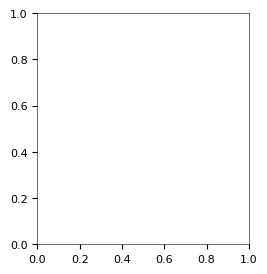

In [ ]:
import pandas as pd
pd.DataFrame(op_policy).fillna(0).T